# This notebook is for Autoencoder model results on train & two test sets (normal & faulty vehicle) for rough road surface

In [2]:
import pandas as pd
import numpy as np
import scipy as sp
import seaborn as sns
import matplotlib.pyplot as plt
import os
import math
import csv

import tensorflow as tf
from keras.layers import Input, Dropout
from keras.layers import Dense 
from keras.models import Model, Sequential, load_model
from keras import regularizers
from keras.models import model_from_json

# Import and read train (subset of Feb - normal vehicle) set

In [86]:
data_vib1 = pd.read_csv("Input_Data_Files/RoughDataTrain.csv", index_col=0)
data_vib1

,FR_LH [m/s2],FR_RH [m/s2],RR_LH [m/s2],RR_RH [m/s2],Cabin [m/s2]
DateTime,,,,,
2020-02-25 16:40:05.600,3.076945,2.005210,0.794605,0.253525,0.680249
2020-02-25 16:40:05.605,-0.643661,-1.515605,1.031323,0.139600,0.285827
2020-02-25 16:40:05.610,2.836121,3.578015,0.940638,0.474731,0.223586
2020-02-25 16:40:05.615,0.456141,-1.551423,1.076140,0.735006,0.603429
2020-02-25 16:40:05.620,0.245845,0.819562,1.121251,0.500910,-0.625381
...,...,...,...,...,...
2020-02-25 15:25:44.810,-2.441289,-0.014932,-0.664579,1.031195,3.263141
2020-02-25 15:25:44.815,1.175209,8.271926,-1.097748,0.689503,1.028962
2020-02-25 15:25:44.820,-2.777858,3.400182,-2.190061,1.966211,-3.580245


# Smoothing of raw train data to reduce noise by rolling mean

In [7]:
data_vib1['Roll_Mean_FR_LH [m/s2]'] = data_vib1[['FR_LH [m/s2]']].rolling(500).mean()
data_vib1['Roll_Mean_FR_RH [m/s2]'] = data_vib1[['FR_RH [m/s2]']].rolling(500).mean()
data_vib1['Roll_Mean_RR_LH [m/s2]'] = data_vib1[['RR_LH [m/s2]']].rolling(500).mean()
data_vib1['Roll_Mean_RR_RH [m/s2]'] = data_vib1[['RR_RH [m/s2]']].rolling(500).mean()
data_vib1['Roll_Mean_Cabin [m/s2]'] = data_vib1[['Cabin [m/s2]']].rolling(500).mean()
data_vib1

,FR_LH [m/s2],FR_RH [m/s2],RR_LH [m/s2],RR_RH [m/s2],Cabin [m/s2],Roll_Mean_FR_LH [m/s2],Roll_Mean_FR_RH [m/s2],Roll_Mean_RR_LH [m/s2],Roll_Mean_RR_RH [m/s2],Roll_Mean_Cabin [m/s2]
DateTime,,,,,,,,,,
2020-02-25 16:40:05.600,3.076945,2.005210,0.794605,0.253525,0.680249,NaN,NaN,NaN,NaN,NaN
2020-02-25 16:40:05.605,-0.643661,-1.515605,1.031323,0.139600,0.285827,NaN,NaN,NaN,NaN,NaN
2020-02-25 16:40:05.610,2.836121,3.578015,0.940638,0.474731,0.223586,NaN,NaN,NaN,NaN,NaN
2020-02-25 16:40:05.615,0.456141,-1.551423,1.076140,0.735006,0.603429,NaN,NaN,NaN,NaN,NaN
2020-02-25 16:40:05.620,0.245845,0.819562,1.121251,0.500910,-0.625381,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...
2020-02-25 15:25:44.810,-2.441289,-0.014932,-0.664579,1.031195,3.263141,0.469565,0.203893,-0.680074,0.714801,0.319279
2020-02-25 15:25:44.815,1.175209,8.271926,-1.097748,0.689503,1.028962,0.469176,0.225851,-0.682445,0.710502,0.318272
2020-02-25 15:25:44.820,-2.777858,3.400182,-2.190061,1.966211,-3.580245,0.472863,0.228143,-0.686841,0.717365,0.300469


In [8]:
data_vib1 = data_vib1.iloc[499:,5:10]
data_vib1

,Roll_Mean_FR_LH [m/s2],Roll_Mean_FR_RH [m/s2],Roll_Mean_RR_LH [m/s2],Roll_Mean_RR_RH [m/s2],Roll_Mean_Cabin [m/s2]
DateTime,,,,,
2020-02-25 16:40:08.095,0.743166,0.176203,0.404520,-0.312269,-0.135470
2020-02-25 16:40:08.100,0.733869,0.165561,0.421476,-0.306290,-0.149068
2020-02-25 16:40:08.105,0.733423,0.162125,0.424986,-0.296458,-0.156636
2020-02-25 16:40:08.110,0.728461,0.148945,0.437839,-0.288681,-0.155216
2020-02-25 16:40:08.115,0.720776,0.146618,0.447231,-0.281277,-0.151334
...,...,...,...,...,...
2020-02-25 15:25:44.810,0.469565,0.203893,-0.680074,0.714801,0.319279
2020-02-25 15:25:44.815,0.469176,0.225851,-0.682445,0.710502,0.318272
2020-02-25 15:25:44.820,0.472863,0.228143,-0.686841,0.717365,0.300469


In [9]:
data_vib1.describe()

,Roll_Mean_FR_LH [m/s2],Roll_Mean_FR_RH [m/s2],Roll_Mean_RR_LH [m/s2],Roll_Mean_RR_RH [m/s2],Roll_Mean_Cabin [m/s2]
count,164433.000000,164433.000000,164433.000000,164433.000000,164433.000000
mean,0.550176,0.237689,-0.135868,0.270140,0.050349
std,0.577747,0.228419,0.672842,0.839605,0.157595
min,-0.594747,-0.456158,-1.306162,-1.638948,-0.535731
25%,0.189145,0.078393,-0.687100,-0.468316,-0.060175
50%,0.370726,0.210355,-0.423050,0.675588,0.050811
75%,0.663239,0.369936,0.373558,0.991602,0.160674
max,2.412649,1.158104,1.591894,1.590511,0.662663


# Training Data Visualization

array([<AxesSubplot:xlabel='DateTime'>, <AxesSubplot:xlabel='DateTime'>,
       <AxesSubplot:xlabel='DateTime'>, <AxesSubplot:xlabel='DateTime'>,
       <AxesSubplot:xlabel='DateTime'>], dtype=object)

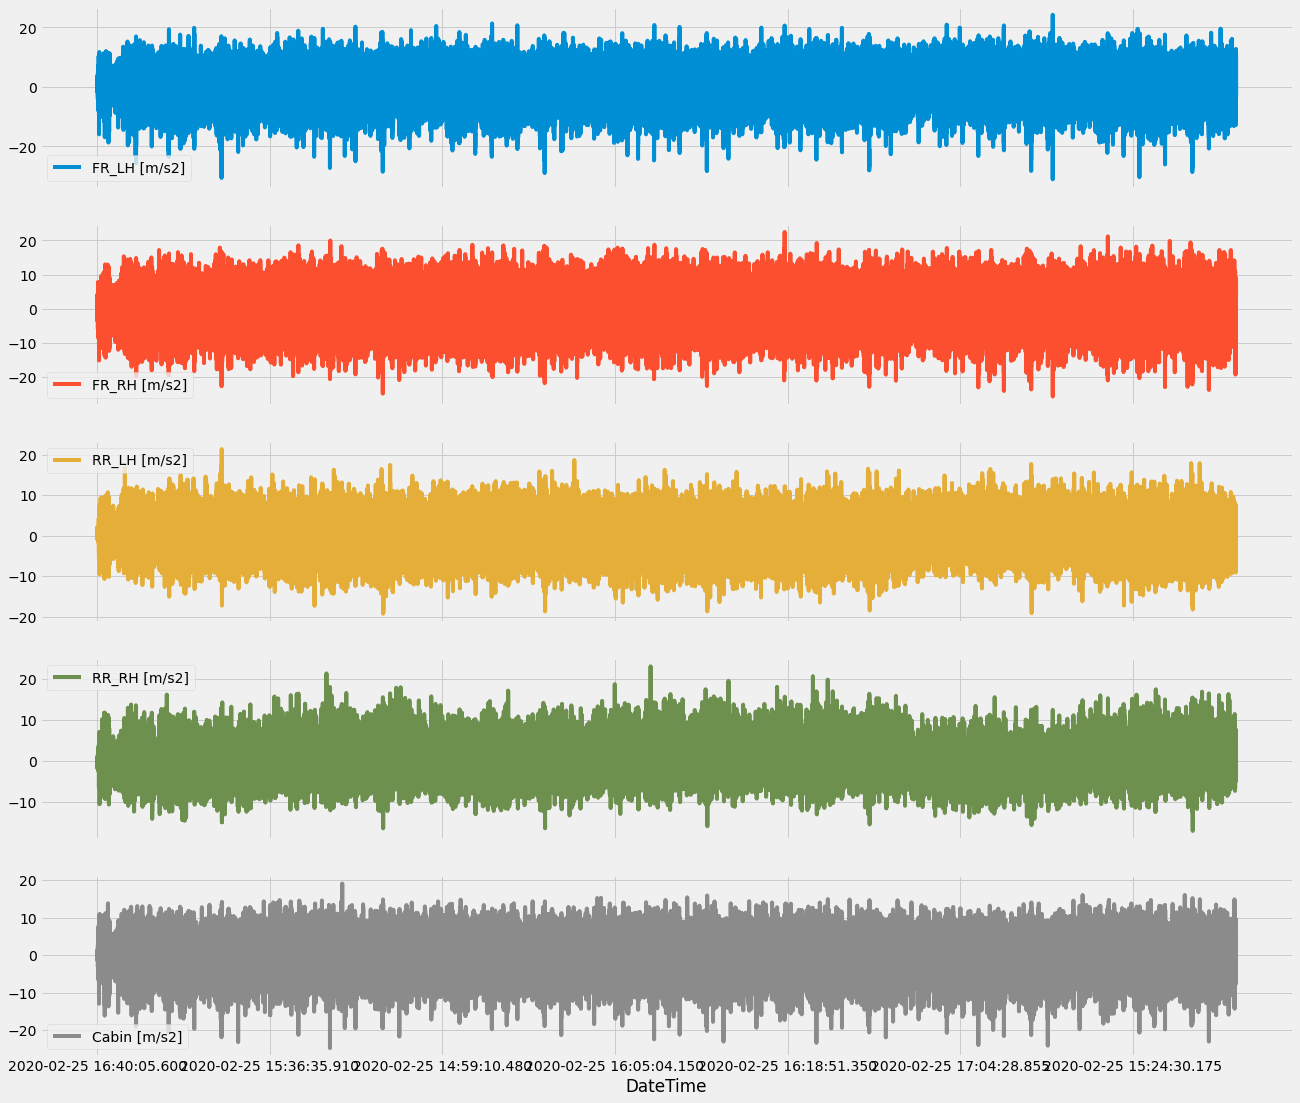

In [87]:
plt.style.use('fivethirtyeight')
data_vib1.plot(figsize=(20,18), subplots=True)

In [11]:
columns = data_vib1.columns
columns

Index(['Roll_Mean_FR_LH [m/s2]', 'Roll_Mean_FR_RH [m/s2]',
       'Roll_Mean_RR_LH [m/s2]', 'Roll_Mean_RR_RH [m/s2]',
       'Roll_Mean_Cabin [m/s2]'],
      dtype='object')

In [12]:
data_train=data_vib1.values
print(data_train)

[[ 0.74316581  0.17620254  0.40451973 -0.31226886 -0.13547037]
 [ 0.73386877  0.16556148  0.42147648 -0.30628957 -0.14906846]
 [ 0.73342334  0.16212536  0.42498639 -0.2964578  -0.15663571]
 ...
 [ 0.47286273  0.22814304 -0.68684144  0.71736477  0.30046885]
 [ 0.49991464  0.2382203  -0.69197822  0.70347261  0.28872001]
 [ 0.4977829   0.24829341 -0.68917366  0.70461228  0.28909163]]


# Import and read test 1 (subset of Feb - normal vehicle) set

In [88]:
data_test1 = pd.read_csv("Input_Data_Files/RoughDataTest_Feb.csv", index_col=0)
data_test1

,FR_LH [m/s2],FR_RH [m/s2],RR_LH [m/s2],RR_RH [m/s2],Cabin [m/s2]
DateTime,,,,,
2020-02-25 15:02:23.430,-8.365533,-6.024143,-6.996150,-3.959084,0.104379
2020-02-25 15:02:23.435,-11.155451,-2.192894,-5.360354,-4.869436,-3.251968
2020-02-25 15:02:23.440,-9.144586,-6.445586,-8.112810,-4.643099,-11.036530
2020-02-25 15:02:23.445,-1.243389,-7.474725,-3.406589,-1.470600,-13.574854
2020-02-25 15:02:23.450,-4.011792,-6.015308,-7.426538,-4.181741,-13.558696
...,...,...,...,...,...
2020-02-25 17:10:11.745,5.369437,-5.901467,3.192574,0.037849,1.845282
2020-02-25 17:10:11.750,-2.640386,-7.980957,4.946055,-1.059476,1.054901
2020-02-25 17:10:11.755,-7.514707,-5.436108,2.104472,-2.563446,-1.928436


# Smoothing of raw test 1 data to reduce noise by rolling mean

In [41]:
data_test1['Roll_Mean_FR_LH [m/s2]'] = data_test1[['FR_LH [m/s2]']].rolling(500).mean()
data_test1['Roll_Mean_FR_RH [m/s2]'] = data_test1[['FR_RH [m/s2]']].rolling(500).mean()
data_test1['Roll_Mean_RR_LH [m/s2]'] = data_test1[['RR_LH [m/s2]']].rolling(500).mean()
data_test1['Roll_Mean_RR_RH [m/s2]'] = data_test1[['RR_RH [m/s2]']].rolling(500).mean()
data_test1['Roll_Mean_Cabin [m/s2]'] = data_test1[['Cabin [m/s2]']].rolling(500).mean()
data_test1

,FR_LH [m/s2],FR_RH [m/s2],RR_LH [m/s2],RR_RH [m/s2],Cabin [m/s2],Roll_Mean_FR_LH [m/s2],Roll_Mean_FR_RH [m/s2],Roll_Mean_RR_LH [m/s2],Roll_Mean_RR_RH [m/s2],Roll_Mean_Cabin [m/s2]
DateTime,,,,,,,,,,
2020-02-25 15:02:23.430,-8.365533,-6.024143,-6.996150,-3.959084,0.104379,NaN,NaN,NaN,NaN,NaN
2020-02-25 15:02:23.435,-11.155451,-2.192894,-5.360354,-4.869436,-3.251968,NaN,NaN,NaN,NaN,NaN
2020-02-25 15:02:23.440,-9.144586,-6.445586,-8.112810,-4.643099,-11.036530,NaN,NaN,NaN,NaN,NaN
2020-02-25 15:02:23.445,-1.243389,-7.474725,-3.406589,-1.470600,-13.574854,NaN,NaN,NaN,NaN,NaN
2020-02-25 15:02:23.450,-4.011792,-6.015308,-7.426538,-4.181741,-13.558696,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...
2020-02-25 17:10:11.745,5.369437,-5.901467,3.192574,0.037849,1.845282,2.024145,0.711983,1.166652,-1.062919,-0.045683
2020-02-25 17:10:11.750,-2.640386,-7.980957,4.946055,-1.059476,1.054901,1.999591,0.690634,1.175464,-1.067493,-0.041915
2020-02-25 17:10:11.755,-7.514707,-5.436108,2.104472,-2.563446,-1.928436,1.965659,0.678403,1.185814,-1.065180,-0.044987


In [42]:
data_test1 = data_test1.iloc[499:,5:10]
data_test1

,Roll_Mean_FR_LH [m/s2],Roll_Mean_FR_RH [m/s2],Roll_Mean_RR_LH [m/s2],Roll_Mean_RR_RH [m/s2],Roll_Mean_Cabin [m/s2]
DateTime,,,,,
2020-02-25 15:02:25.925,0.198106,0.041139,0.215469,0.022873,-0.003148
2020-02-25 15:02:25.930,0.210868,0.035730,0.225419,0.027036,0.008403
2020-02-25 15:02:25.935,0.217123,0.028177,0.235132,0.041051,0.022007
2020-02-25 15:02:25.940,0.222701,0.045094,0.247437,0.045748,0.039325
2020-02-25 15:02:25.945,0.225018,0.058445,0.253115,0.049694,0.060226
...,...,...,...,...,...
2020-02-25 17:10:11.745,2.024145,0.711983,1.166652,-1.062919,-0.045683
2020-02-25 17:10:11.750,1.999591,0.690634,1.175464,-1.067493,-0.041915
2020-02-25 17:10:11.755,1.965659,0.678403,1.185814,-1.065180,-0.044987


In [43]:
data_test1.describe()

,Roll_Mean_FR_LH [m/s2],Roll_Mean_FR_RH [m/s2],Roll_Mean_RR_LH [m/s2],Roll_Mean_RR_RH [m/s2],Roll_Mean_Cabin [m/s2]
count,187018.000000,187018.000000,187018.000000,187018.000000,187018.000000
mean,0.752052,0.295001,-0.043672,0.138083,0.053320
std,0.534354,0.211304,0.667552,0.782950,0.165949
min,-0.294572,-0.366428,-1.315483,-1.638515,-0.553479
25%,0.383231,0.147405,-0.647072,-0.466912,-0.062936
50%,0.583793,0.270718,-0.096624,0.164255,0.058204
75%,0.956761,0.412580,0.432638,0.863226,0.170389
max,2.580851,1.243211,1.622904,1.620203,0.682525


# Test 1 Data Visualization

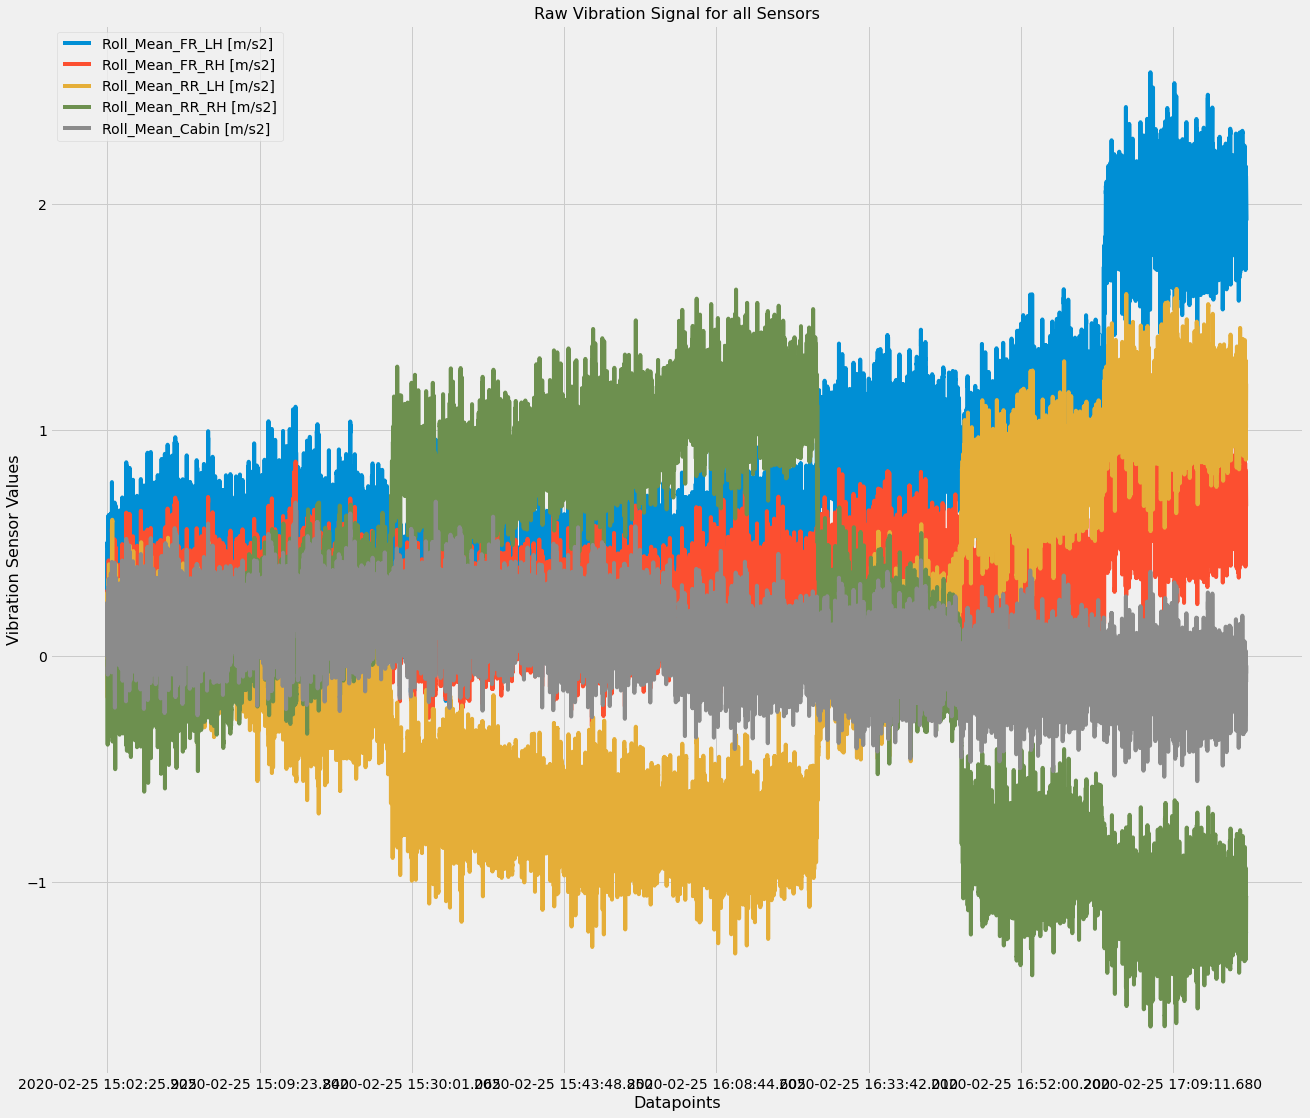

In [45]:
plt.style.use('fivethirtyeight')
ax = data_test1.plot(figsize=(20,18), subplots=False)
ax.set_xlabel('Datapoints', fontsize=16)
ax.set_ylabel('Vibration Sensor Values', fontsize=16)
ax.set_title('Raw Vibration Signal for all Sensors', fontsize=16)
plt.show()

In [46]:
data_test_feb_columns = data_test1.columns
data_test_feb_columns

Index(['Roll_Mean_FR_LH [m/s2]', 'Roll_Mean_FR_RH [m/s2]',
       'Roll_Mean_RR_LH [m/s2]', 'Roll_Mean_RR_RH [m/s2]',
       'Roll_Mean_Cabin [m/s2]'],
      dtype='object')

In [47]:
data_test_feb=data_test1.values
print(data_test_feb)

[[ 0.19810603  0.04113908  0.21546868  0.02287283 -0.00314812]
 [ 0.21086756  0.03572987  0.2254185   0.02703584  0.00840343]
 [ 0.21712297  0.02817658  0.23513194  0.04105114  0.02200679]
 ...
 [ 1.96565934  0.67840312  1.18581413 -1.0651798  -0.04498736]
 [ 1.94396048  0.66706021  1.19382614 -1.06953685 -0.05467214]
 [ 1.92588133  0.6620823   1.20373502 -1.06642297 -0.07764045]]


# Import and read test 2 (subset of March - faulty vehicle) set

In [89]:
data_test2 = pd.read_csv("Input_Data_Files/RoughDataTest_March.csv", index_col=0)
data_test2

,FR_LH [m/s2],FR_RH [m/s2],RR_LH [m/s2],RR_RH [m/s2],Cabin [m/s2]
0,-0.109129,0.269935,-0.024388,-0.587521,-0.507254
1,-1.158863,-0.648579,0.116042,-0.475152,-0.627271
2,1.120434,1.628541,-0.388099,-0.725018,-0.721889
3,0.210317,-0.080098,-0.126867,-0.494602,0.020062
4,-0.746655,-0.189759,-0.002654,-0.590191,-0.229920
...,...,...,...,...,...
186729,1.132726,-1.314885,-1.803605,-2.097189,-1.354829
186730,12.078911,-0.824037,2.005994,-1.835569,-4.798110
186731,4.121930,1.390165,3.140303,-0.728109,-3.841607
186732,8.487017,0.061375,0.673888,-2.869897,-0.467234


# Smoothing of raw test 2 data to reduce noise by rolling mean

In [50]:
data_test2['Roll_Mean_FR_LH [m/s2]'] = data_test2[['FR_LH [m/s2]']].rolling(500).mean()
data_test2['Roll_Mean_FR_RH [m/s2]'] = data_test2[['FR_RH [m/s2]']].rolling(500).mean()
data_test2['Roll_Mean_RR_LH [m/s2]'] = data_test2[['RR_LH [m/s2]']].rolling(500).mean()
data_test2['Roll_Mean_RR_RH [m/s2]'] = data_test2[['RR_RH [m/s2]']].rolling(500).mean()
data_test2['Roll_Mean_Cabin [m/s2]'] = data_test2[['Cabin [m/s2]']].rolling(500).mean()
data_test2

,FR_LH [m/s2],FR_RH [m/s2],RR_LH [m/s2],RR_RH [m/s2],Cabin [m/s2],Roll_Mean_FR_LH [m/s2],Roll_Mean_FR_RH [m/s2],Roll_Mean_RR_LH [m/s2],Roll_Mean_RR_RH [m/s2],Roll_Mean_Cabin [m/s2]
0,-0.109129,0.269935,-0.024388,-0.587521,-0.507254,NaN,NaN,NaN,NaN,NaN
1,-1.158863,-0.648579,0.116042,-0.475152,-0.627271,NaN,NaN,NaN,NaN,NaN
2,1.120434,1.628541,-0.388099,-0.725018,-0.721889,NaN,NaN,NaN,NaN,NaN
3,0.210317,-0.080098,-0.126867,-0.494602,0.020062,NaN,NaN,NaN,NaN,NaN
4,-0.746655,-0.189759,-0.002654,-0.590191,-0.229920,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...
186729,1.132726,-1.314885,-1.803605,-2.097189,-1.354829,5.576831,2.161645,1.382755,-2.271221,-0.080819
186730,12.078911,-0.824037,2.005994,-1.835569,-4.798110,5.602047,2.164527,1.394508,-2.263767,-0.090503
186731,4.121930,1.390165,3.140303,-0.728109,-3.841607,5.610037,2.166455,1.396667,-2.258902,-0.100664
186732,8.487017,0.061375,0.673888,-2.869897,-0.467234,5.622748,2.166539,1.401922,-2.251667,-0.101089


In [51]:
data_test2 = data_test2.iloc[499:,5:10]
data_test2

,Roll_Mean_FR_LH [m/s2],Roll_Mean_FR_RH [m/s2],Roll_Mean_RR_LH [m/s2],Roll_Mean_RR_RH [m/s2],Roll_Mean_Cabin [m/s2]
499,0.262234,0.424560,0.489393,0.071883,-0.332403
500,0.272255,0.426089,0.495916,0.075224,-0.329507
501,0.277599,0.421451,0.501233,0.080916,-0.322198
502,0.279515,0.417917,0.504086,0.084280,-0.312624
503,0.285675,0.422742,0.513679,0.091405,-0.307148
...,...,...,...,...,...
186729,5.576831,2.161645,1.382755,-2.271221,-0.080819
186730,5.602047,2.164527,1.394508,-2.263767,-0.090503
186731,5.610037,2.166455,1.396667,-2.258902,-0.100664
186732,5.622748,2.166539,1.401922,-2.251667,-0.101089


In [52]:
data_test2.describe()

,Roll_Mean_FR_LH [m/s2],Roll_Mean_FR_RH [m/s2],Roll_Mean_RR_LH [m/s2],Roll_Mean_RR_RH [m/s2],Roll_Mean_Cabin [m/s2]
count,186235.000000,186235.000000,186235.000000,186235.000000,186235.000000
mean,2.709028,1.338257,0.392614,-0.070043,0.275245
std,1.892324,0.571262,0.900408,1.355656,0.558684
min,-0.455840,0.110384,-1.564077,-2.615244,-0.781303
25%,0.975342,0.867797,-0.429864,-0.588909,-0.165029
50%,2.408043,1.254122,0.546508,0.031190,0.035087
75%,4.262537,1.794761,1.098845,1.102297,0.822002
max,6.136497,2.848929,2.128863,2.316158,1.863617


# Test 2 Data Visualization

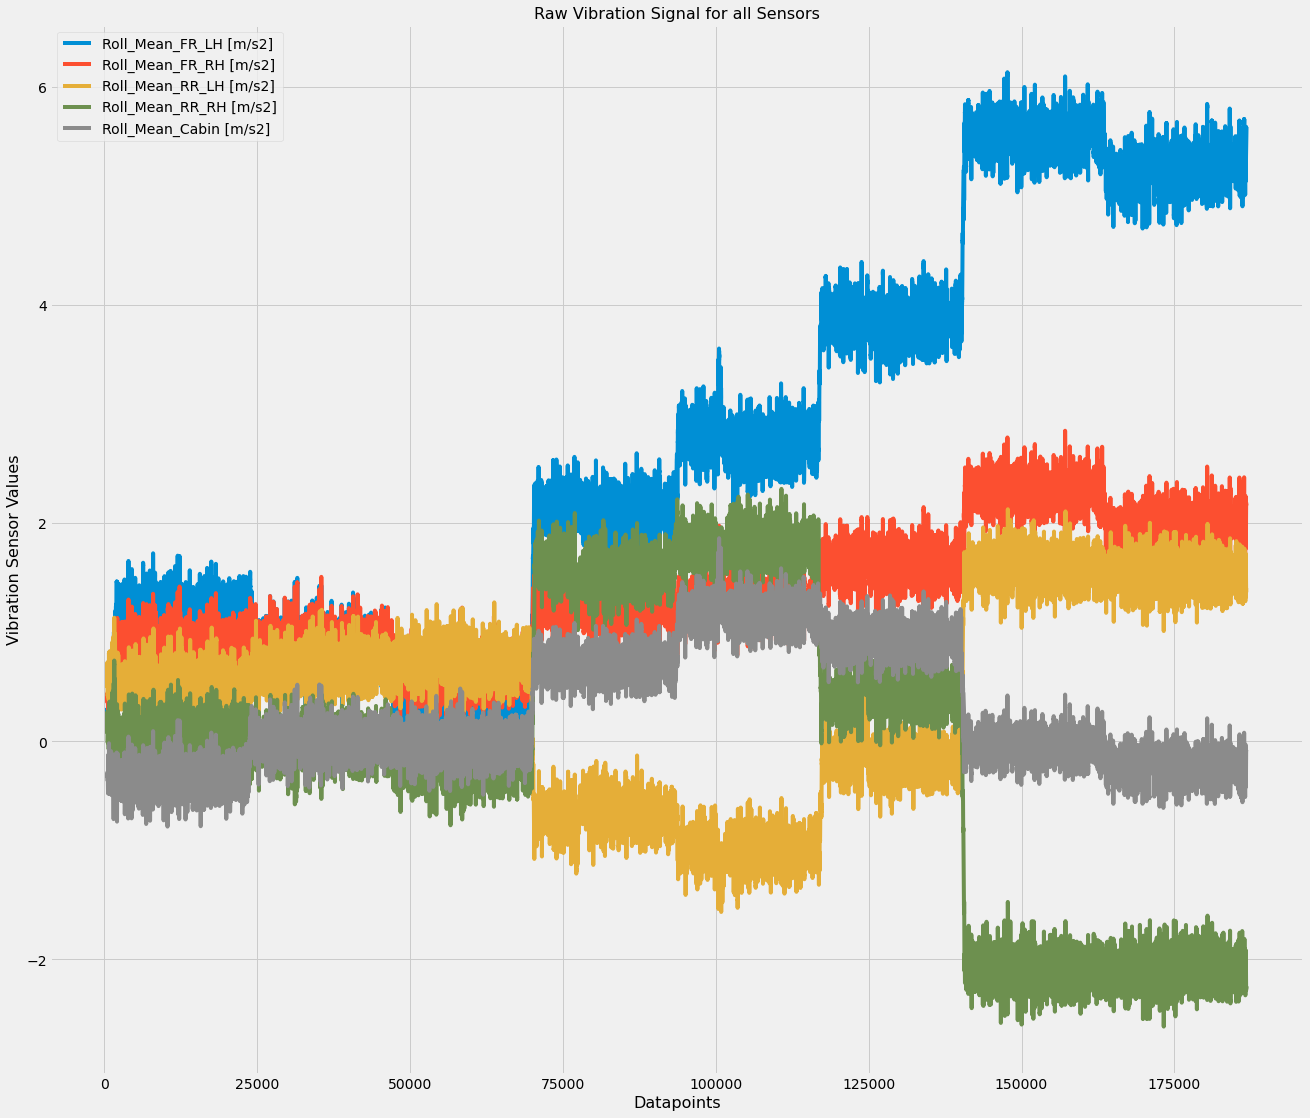

In [53]:
plt.style.use('fivethirtyeight')
ax = data_test2.plot(figsize=(20,18), subplots=False)
ax.set_xlabel('Datapoints', fontsize=16)
ax.set_ylabel('Vibration Sensor Values', fontsize=16)
ax.set_title('Raw Vibration Signal for all Sensors', fontsize=16)
plt.show()

In [54]:
data_test_march_columns = data_test2.columns
data_test_march_columns

Index(['Roll_Mean_FR_LH [m/s2]', 'Roll_Mean_FR_RH [m/s2]',
       'Roll_Mean_RR_LH [m/s2]', 'Roll_Mean_RR_RH [m/s2]',
       'Roll_Mean_Cabin [m/s2]'],
      dtype='object')

In [55]:
data_test_march=data_test2.values
print(data_test_march)

[[ 0.26223413  0.42455964  0.48939304  0.07188333 -0.33240328]
 [ 0.27225541  0.42608933  0.49591643  0.07522392 -0.32950692]
 [ 0.27759883  0.42145053  0.50123348  0.08091565 -0.32219843]
 ...
 [ 5.61003719  2.16645477  1.3966667  -2.2589022  -0.10066435]
 [ 5.62274762  2.16653917  1.40192226 -2.25166704 -0.10108947]
 [ 5.63421783  2.19390851  1.40718506 -2.24675614 -0.09056941]]


# Compile & fit Autoencoder model

In [65]:
input_dim = data_train.shape[1]


input_layer = Input(shape=(input_dim, ))

encoder1 = Dense(4, activation="tanh",
        activity_regularizer=regularizers.l1(10e-5),kernel_initializer='glorot_uniform')(input_layer)

# encoder2 = Dense(7, activation="relu",kernel_initializer='glorot_uniform')(encoder1)

encoder3 = Dense(2, activation='relu',kernel_initializer='glorot_uniform')(encoder1)

# decoder1 = Dense(7, activation='relu',kernel_initializer='glorot_uniform')(encoder3)

decoder2 = Dense(4, activation='tanh',kernel_initializer='glorot_uniform')(encoder3)

decoder3 = Dense(input_dim, kernel_initializer='glorot_uniform')(decoder2)

autoencoder = Model(inputs=input_layer, outputs=decoder3)

nb_epoch = 100
batch_size = 64

autoencoder.compile(optimizer='adam', loss='mean_squared_error')

In [66]:
autoencoder.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 5)]               0         
                                                                 
 dense_4 (Dense)             (None, 4)                 24        
                                                                 
 dense_5 (Dense)             (None, 2)                 10        
                                                                 
 dense_6 (Dense)             (None, 4)                 12        
                                                                 
 dense_7 (Dense)             (None, 5)                 25        
                                                                 
Total params: 71 (284.00 Byte)
Trainable params: 71 (284.00 Byte)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [67]:
history=autoencoder.fit(data_train,data_train,
                  batch_size=batch_size, 
                  epochs=nb_epoch,
                  validation_split=0.15,
                  verbose = 1)

Epoch 1/100
2184/2184 [==============================] - 7s 3ms/step - loss: 0.0911 - val_loss: 0.0179
Epoch 2/100
2184/2184 [==============================] - 7s 3ms/step - loss: 0.0148 - val_loss: 0.0112
Epoch 3/100
2184/2184 [==============================] - 6s 3ms/step - loss: 0.0123 - val_loss: 0.0098
Epoch 4/100
2184/2184 [==============================] - 6s 3ms/step - loss: 0.0109 - val_loss: 0.0095
Epoch 5/100
2184/2184 [==============================] - 6s 3ms/step - loss: 0.0102 - val_loss: 0.0109
Epoch 6/100
2184/2184 [==============================] - 6s 3ms/step - loss: 0.0098 - val_loss: 0.0130
Epoch 7/100
2184/2184 [==============================] - 6s 3ms/step - loss: 0.0096 - val_loss: 0.0135
Epoch 8/100
2184/2184 [==============================] - 6s 3ms/step - loss: 0.0095 - val_loss: 0.0147
Epoch 9/100
2184/2184 [==============================] - 6s 3ms/step - loss: 0.0093 - val_loss: 0.0163
Epoch 10/100
2184/2184 [==============================] - 6s 3ms/step - l

Epoch 80/100
2184/2184 [==============================] - 6s 3ms/step - loss: 0.0070 - val_loss: 0.0107
Epoch 81/100
2184/2184 [==============================] - 7s 3ms/step - loss: 0.0069 - val_loss: 0.0110
Epoch 82/100
2184/2184 [==============================] - 6s 3ms/step - loss: 0.0069 - val_loss: 0.0111
Epoch 83/100
2184/2184 [==============================] - 7s 3ms/step - loss: 0.0069 - val_loss: 0.0112
Epoch 84/100
2184/2184 [==============================] - 7s 3ms/step - loss: 0.0069 - val_loss: 0.0114
Epoch 85/100
2184/2184 [==============================] - 7s 3ms/step - loss: 0.0069 - val_loss: 0.0109
Epoch 86/100
2184/2184 [==============================] - 7s 3ms/step - loss: 0.0069 - val_loss: 0.0105
Epoch 87/100
2184/2184 [==============================] - 6s 3ms/step - loss: 0.0069 - val_loss: 0.0116
Epoch 88/100
2184/2184 [==============================] - 6s 3ms/step - loss: 0.0069 - val_loss: 0.0103
Epoch 89/100
2184/2184 [==============================] - 8s 4ms

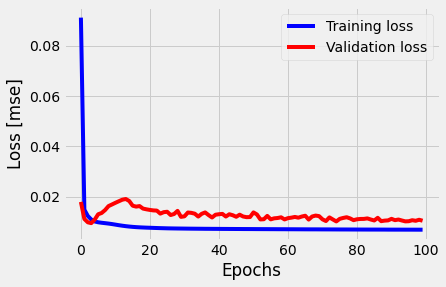

In [68]:
plt.plot(history.history['loss'], 'b', label='Training loss')
plt.plot(history.history['val_loss'], 'r', label='Validation loss')
plt.legend(loc='upper right')
plt.xlabel('Epochs')
plt.ylabel('Loss [mse]')
plt.show()

# Predict the results on train set

In [69]:
X_pred = autoencoder.predict(data_train)
X_pred = pd.DataFrame(X_pred, 
                      columns=data_vib1.columns)
X_pred.index = data_vib1.index

scored_train = pd.DataFrame(index=data_vib1.index)
scored_train['Loss_Train_MAE'] = np.mean(np.abs(X_pred-data_train), axis = 1)
scored_train

5139/5139 [==============================] - 10s 2ms/step


,Loss_Train_MAE
DateTime,
2020-02-25 16:40:08.095,0.215333
2020-02-25 16:40:08.100,0.216723
2020-02-25 16:40:08.105,0.219517
2020-02-25 16:40:08.110,0.221458
2020-02-25 16:40:08.115,0.220975
...,...
2020-02-25 15:25:44.810,0.073831
2020-02-25 15:25:44.815,0.068859
2020-02-25 15:25:44.820,0.065247


In [70]:
scored_train_asc = scored_train.sort_values(by=['Loss_Train_MAE'], ascending=False)
scored_train_asc

,Loss_Train_MAE
DateTime,
2020-02-25 17:03:54.800,0.435720
2020-02-25 17:03:54.825,0.432525
2020-02-25 17:03:54.805,0.431750
2020-02-25 17:03:54.810,0.431288
2020-02-25 17:03:54.820,0.430124
...,...
2020-02-25 17:05:57.480,0.002514
2020-02-25 17:03:59.335,0.002506
2020-02-25 17:04:08.655,0.002288


C:\Users\Khyati.Thakkar\Anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


Text(0.5, 1.0, 'MAE Loss for Rough Training Data')

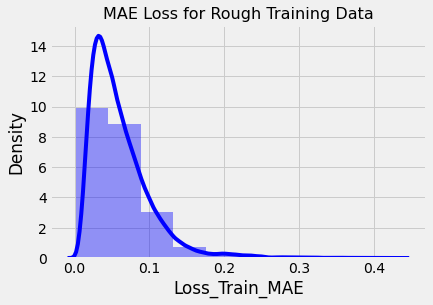

In [71]:
plt.figure()
ax=sns.distplot(scored_train['Loss_Train_MAE'],
             bins = 10, 
             kde= True,
            color = 'blue');
ax.set_title('MAE Loss for Rough Training Data', fontsize=16)

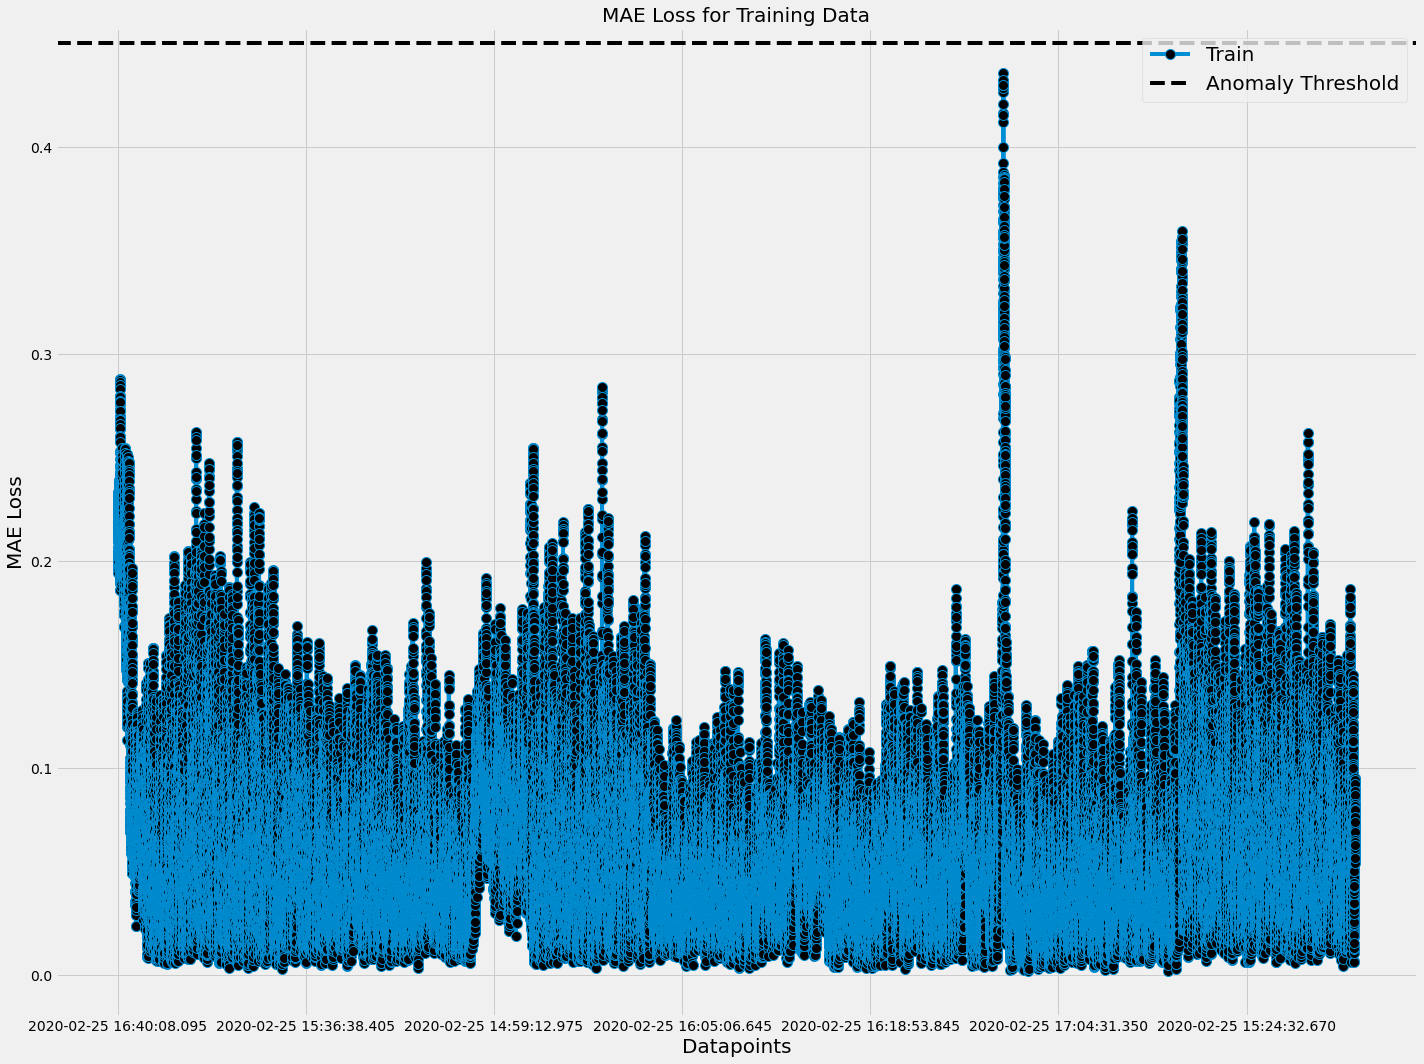

In [72]:
ax = scored_train['Loss_Train_MAE'].plot(figsize=(20,15), marker='o', markersize=10, markerfacecolor='black')
ax.set_xlabel('Datapoints', fontsize=20)
ax.set_ylabel('MAE Loss', fontsize=20)
ax.set_title('MAE Loss for Training Data', fontsize=20)
ax.legend(fontsize=20)
plt.axhline(0.45, color='k', linestyle='--')
ax.legend(("Train", "Anomaly Threshold"), fontsize=20)
plt.tight_layout()

# Predict the results on test 1 set

In [75]:
X_pred_test1 = autoencoder.predict(data_test_feb)
X_pred_test1 = pd.DataFrame(X_pred_test1, 
                      columns=data_test1.columns)
X_pred_test1.index = data_test1.index

scored_test_feb = pd.DataFrame(index=data_test1.index)
scored_test_feb['Loss_TestFeb_MAE'] = np.mean(np.abs(X_pred_test1-data_test_feb), axis = 1)
scored_test_feb_asc = scored_test_feb.sort_values(by=['Loss_TestFeb_MAE'], ascending=False)
scored_test_feb_asc

5845/5845 [==============================] - 11s 2ms/step


,Loss_TestFeb_MAE
DateTime,
2020-02-25 16:34:25.350,0.407268
2020-02-25 16:34:25.380,0.406327
2020-02-25 16:34:25.345,0.406103
2020-02-25 16:34:25.355,0.405648
2020-02-25 16:34:25.360,0.405472
...,...
2020-02-25 17:10:01.760,0.002652
2020-02-25 17:07:53.845,0.002492
2020-02-25 16:10:41.425,0.002482


C:\Users\Khyati.Thakkar\Anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


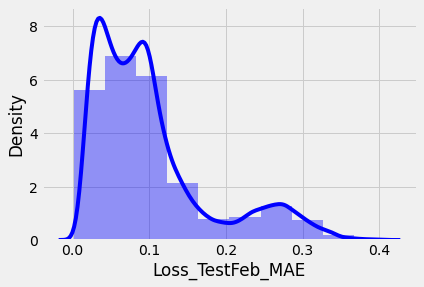

In [76]:
plt.figure()
sns.distplot(scored_test_feb['Loss_TestFeb_MAE'],
             bins = 10, 
             kde= True,
            color = 'blue');

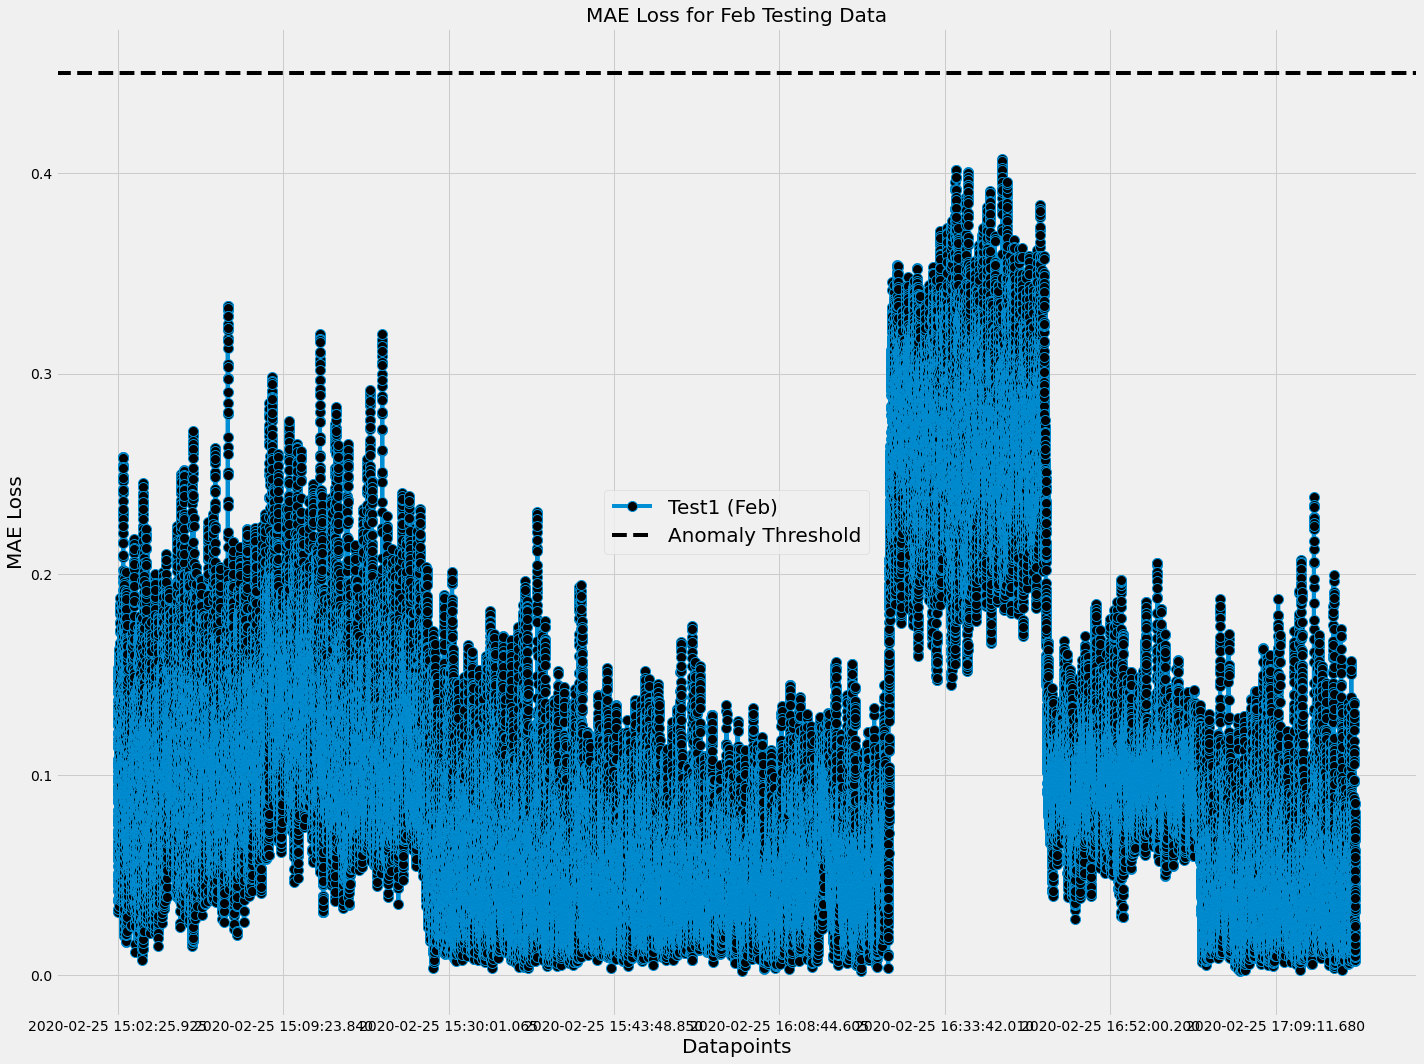

In [77]:
ax = scored_test_feb['Loss_TestFeb_MAE'].plot(figsize=(20,15), marker='o', markersize=10, markerfacecolor='black')
ax.set_xlabel('Datapoints', fontsize=20)
ax.set_ylabel('MAE Loss', fontsize=20)
ax.set_title('MAE Loss for Feb Testing Data', fontsize=20)
ax.legend(fontsize=20)
plt.axhline(0.45, color='k', linestyle='--')
ax.legend(("Test1 (Feb)", "Anomaly Threshold"), fontsize=20)
plt.tight_layout()

# Predict the results on test 2 set

In [78]:
X_pred = autoencoder.predict(data_test_march)
X_pred = pd.DataFrame(X_pred, 
                      columns=data_test2.columns)
X_pred.index = data_test2.index

scored_test_march = pd.DataFrame(index=data_test2.index)
scored_test_march['Loss_TestMarch_MAE'] = np.mean(np.abs(X_pred-data_test_march), axis = 1)
scored_test_march_asc = scored_test_march.sort_values(by=['Loss_TestMarch_MAE'], ascending=False)
scored_test_march_asc

5820/5820 [==============================] - 11s 2ms/step


,Loss_TestMarch_MAE
147704,1.903793
149175,1.901860
149074,1.900391
147702,1.898747
149176,1.898700
...,...
64288,0.162450
57295,0.161790
56001,0.161015
57297,0.159988


C:\Users\Khyati.Thakkar\Anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


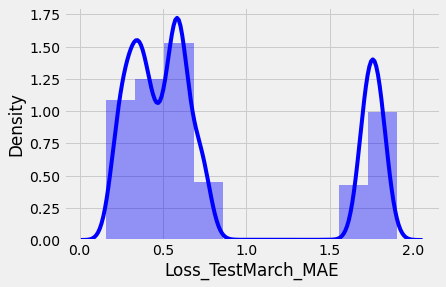

In [79]:
plt.figure()
sns.distplot(scored_test_march['Loss_TestMarch_MAE'],
             bins = 10, 
             kde= True,
            color = 'blue');

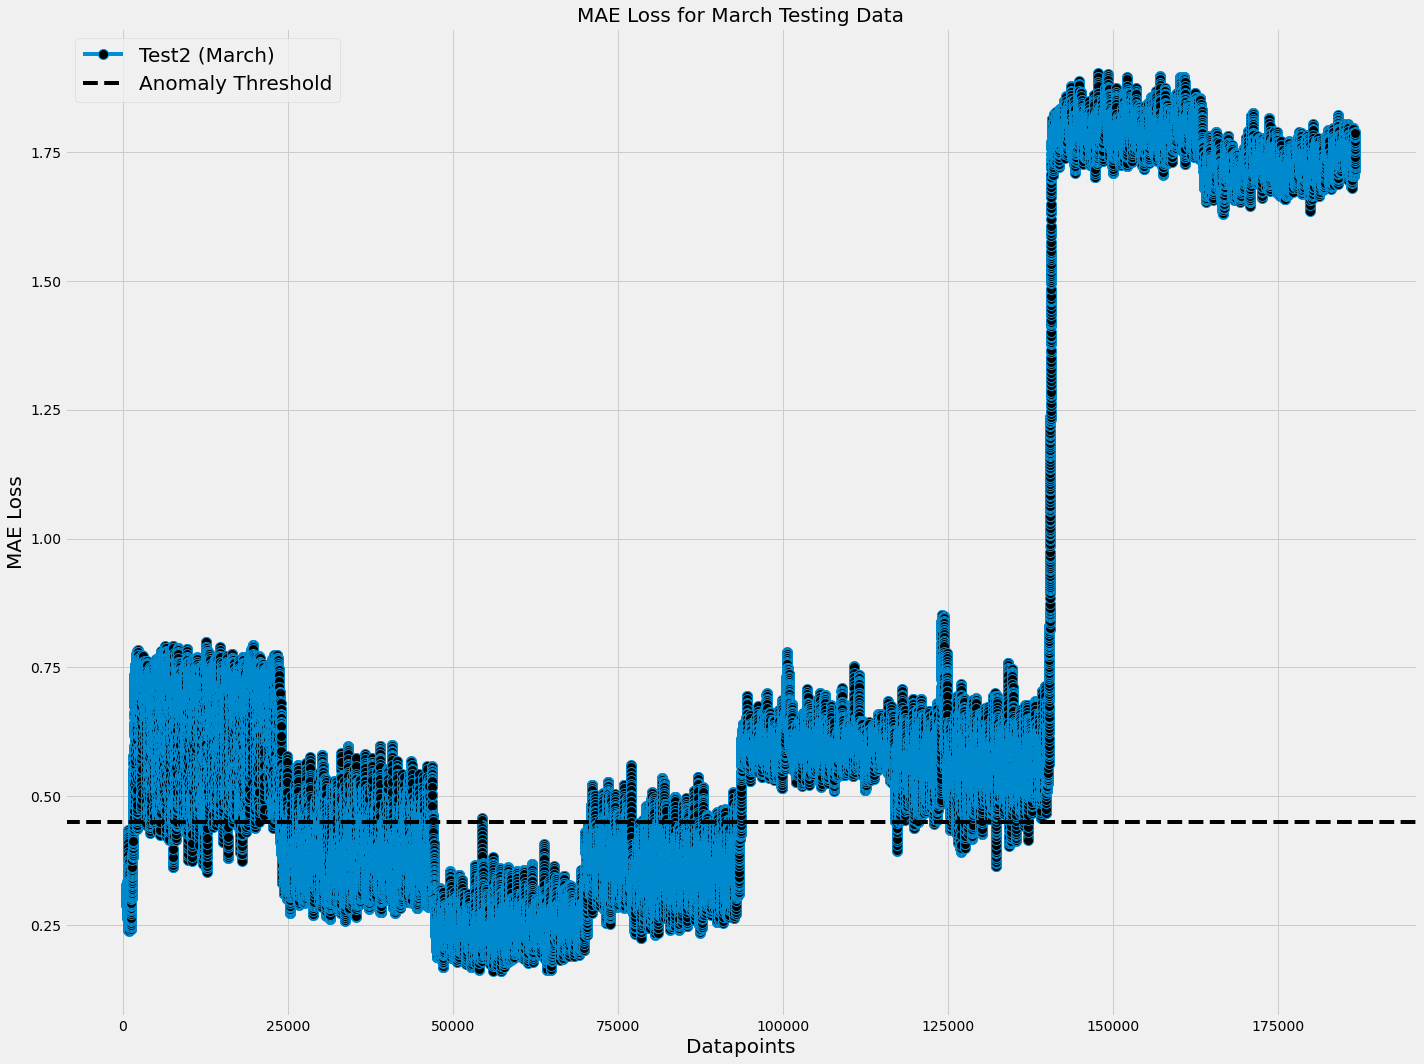

In [81]:
ax = scored_test_march['Loss_TestMarch_MAE'].plot(figsize=(20,15), marker='o', markersize=10, markerfacecolor='black')
ax.set_xlabel('Datapoints', fontsize=20)
ax.set_ylabel('MAE Loss', fontsize=20)
ax.set_title('MAE Loss for March Testing Data', fontsize=20)
ax.legend(fontsize=20)
plt.axhline(0.45, color='k', linestyle='--')
ax.legend(("Test2 (March)", "Anomaly Threshold"), fontsize=20)
plt.tight_layout()

# Compare and plot predictions on both the test sets (Test 1 & Test 2)

In [82]:
test_feb = scored_test_feb[['Loss_TestFeb_MAE']].reset_index()
test_march = scored_test_march[['Loss_TestMarch_MAE']].reset_index()

In [83]:
graph = pd.concat([test_feb["Loss_TestFeb_MAE"], test_march["Loss_TestMarch_MAE"]] ,axis=1)
graph.columns = ['Test1 (Feb)', 'Test2 (March)']
graph

,Test1 (Feb),Test2 (March)
0,0.096966,0.288014
1,0.101805,0.289894
2,0.105916,0.290464
3,0.105367,0.290224
4,0.104211,0.292817
...,...,...
187013,0.048104,NaN
187014,0.043251,NaN
187015,0.041884,NaN
187016,0.040407,NaN


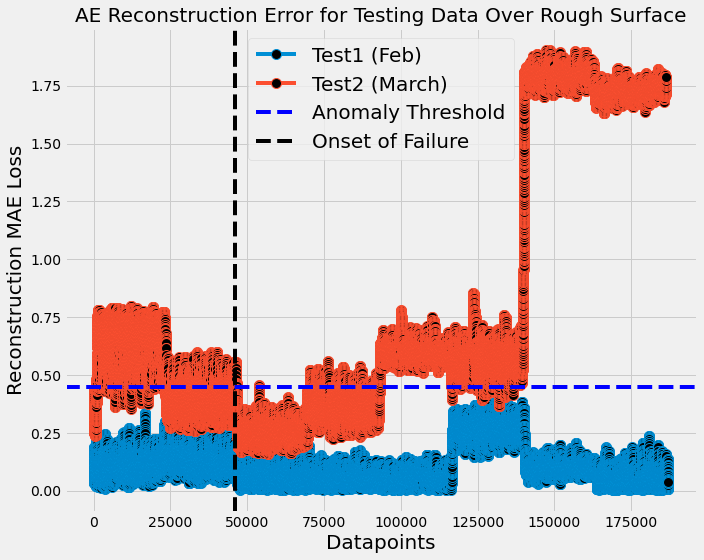

In [85]:
ax = graph.plot(figsize=(10,8), marker='o', markersize=10, markerfacecolor='black')
ax.set_xlabel('Datapoints', fontsize=20)
ax.set_ylabel('Reconstruction MAE Loss', fontsize=20)
ax.set_title('AE Reconstruction Error for Testing Data Over Rough Surface', fontsize=20)
ax.legend(fontsize=20) # using a size in points
plt.axhline(0.45, color='blue', linestyle='--')
plt.axvline(46040, color='black', linestyle='--')
ax.legend(("Test1 (Feb)", "Test2 (March)", "Anomaly Threshold", "Onset of Failure"), fontsize=20)
plt.tight_layout()